# Programming Assignment 7.2. Grover's Search Algorithm End to End

In the second part of this assignment, you will explore the behavior of Grover's search algorithm on Kakuro puzzle instances of increasing size.

In [2]:
import qsharp

## The phase oracle (not graded)
The first step of solving a problem using Grover's algorithm is defining an oracle. 

**This step is not graded in the notebook! You need to use the oracle you implemented in task 4 of the assignment 7.1 and the phase kickback trick. You can use the testing harness from that assignment to check that your solution is correct.**

In [3]:
%%qsharp
operation KakuroPhaseOracle(
    qs : Qubit[], 
    rowConstr : Int[], 
    colConstr : Int[]
) : Unit is Adj + Ctl {
    use aux = Qubit();

    within {
        Task4(qs, aux, rowConstr, colConstr);
    } apply {
        Z(aux);
    }
}

operation Task4(
    x : Qubit[], 
    y : Qubit,
    rowConstr : Int[],
    colConstr : Int[]
) : Unit is Adj + Ctl {
    let R = Length(rowConstr);
    let C = Length(colConstr);
    let totalQubits = Length(x);

    let rowSumRegSize = Microsoft.Quantum.Math.BitSizeI(C + 1);
    let colSumRegSize = Microsoft.Quantum.Math.BitSizeI(R + 1);

    use rowSumRegs = Qubit[R * rowSumRegSize];
    use colSumRegs = Qubit[C * colSumRegSize];
    use rowAux = Qubit[R];
    use colAux = Qubit[C];

    within {
        for r in 0 .. R - 1 {
            let sumRegStart = r * rowSumRegSize;
            let sumRegEnd = sumRegStart + rowSumRegSize - 1;
            let sumReg = rowSumRegs[sumRegStart .. sumRegEnd];

            for c in 0 .. C - 1 {
                let idx = r * C + c;
                let q = x[idx];

                Controlled IncrementLE([q], sumReg);
            }

            ApplyControlledOnInt(rowConstr[r], X, sumReg, rowAux[r]);
        }

        for c in 0 .. C - 1 {
            let sumRegStart = c * colSumRegSize;
            let sumRegEnd = sumRegStart + colSumRegSize - 1;
            let sumReg = colSumRegs[sumRegStart .. sumRegEnd];

            for r in 0 .. R - 1 {
                let idx = r * C + c;
                let q = x[idx];

                Controlled IncrementLE([q], sumReg);
            }

            ApplyControlledOnInt(colConstr[c], X, sumReg, colAux[c]);
        }
    } apply {
        let allAux = rowAux + colAux;
        Controlled X(allAux, y);
    }
}

operation IncrementLE(register : Qubit[]) : Unit is Adj + Ctl {
    if Length(register) > 1 {
        Controlled IncrementLE([register[0]], register[1 ...]);
    }
    X(register[0]);
}

### Task 1. Find the optimal number of iterations for two puzzles (2 points = 1 point per puzzle)

Your task is to calculate the optimal number of iterations for two small puzzles based on the size of the search space and the known number of problem solutions. **Write the answer and your calculations in separate cells in this notebook.**

#### Puzzle 1.

|   | 1 | 1 |
|---|---|---|
| **1** |   |   |
| **1** |   |   |

#### Puzzle 1 Solution and Answer

**Write your calculations here**

#### Formula for Optimal Iterations:

$$
k = \left\lfloor \frac{\pi}{4} \sqrt{\frac{N}{M}} \right\rfloor
$$

Where:
- \(N\): Total number of possible states (search space size).
- \(M\): Number of valid solutions.
- \(k\): Optimal number of iterations (rounded down).

1. **Search Space Size \(N\)**:  
   The puzzle is **2x2**, requiring **4 qubits**, so:

   $$
   N = 2^4 = 16
   $$

2. **Number of Valid Solutions \(M\)**:  
   The puzzle has **2 solutions**.
   
3. **Optimal Number of Iterations \(k_1\)**:

   $$
   k_1 = \left\lfloor \frac{\pi}{4} \sqrt{\frac{16}{2}} \right\rfloor
   $$

   $$
   = \left\lfloor \frac{\pi}{4} \times \sqrt{8} \right\rfloor
   $$

   $$
   = \left\lfloor \frac{\pi}{4} \times 2\sqrt{2} \right\rfloor
   $$

   $$
   = \left\lfloor 2.22 \right\rfloor = 2
   $$

4. **Conclusion for Puzzle 1**:  
   - **Optimal Iterations \(k_1\)**: **2**

#### Puzzle 2.

|   | 1 | 2 | 1 |
|---|---|---|---|
| **1** |   |   |   |
| **2** |   |   |   |
| **1** |   |   |   |

#### Puzzle 2 Solution and Answer

**Write your calculations here**

1. **Search Space Size \(N\)**: 
The puzzle is **3x3**, requiring **9 qubits**, so:

$$
N = 2^9 = 512
$$

2. **Number of Valid Solutions \(M\)**:  
Based on the latest plot, the puzzle has **5 valid solutions**.

3. **Optimal Number of Iterations \(k_1\)**:


$$
k_2 = \left\lfloor \frac{\pi}{4} \sqrt{\frac{512}{5}} \right\rfloor
$$

$$
= \left\lfloor \frac{\pi}{4} \times \sqrt{102.4} \right\rfloor
$$

$$
= \left\lfloor 7.95 \right\rfloor = 7
$$

4. **Conclusion for Puzzle 1**:  
- **Optimal Iterations \(k_2\)**: **7**

### Task 2. Solve the two puzzles using Grover's search (2 points = 1 point per puzzle)

Your task is to use the provided Grover's search implementation to solve the two puzzles from task 1. Use the optimal number of iterations you've calculated in task 1. **Plot the results using the provided code, indicate the correct results among all results, and save the plots as part of the notebook.**

In [4]:
%%qsharp
operation KakuroGroversSearch(iterations : Int, rowConstr : Int[], colConstr : Int[]) : Result[] {
    let N = Length(rowConstr) * Length(colConstr);
    use qs = Qubit[N];
    ApplyToEach(H, qs);

    for i in 1 .. iterations {
        KakuroPhaseOracle(qs, rowConstr, colConstr);
        
        within {
            ApplyToEachA(H, qs);
            ApplyToEachA(X, qs);
        } apply {
            Controlled Z(qs[...N - 2], qs[N - 1]);
        }
    }
    MResetEachZ(qs)
}

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_results(results):
    string_counts = Counter(results)
    labels, values = zip(*sorted(string_counts.items()))

    plt.bar(labels, values)
    plt.xlabel('Results')
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    plt.title('Histogram of Kakuro Puzzle Solutions')
    plt.show()

Edit the number of iterations in the code cell below and run it to plot the results. **Which of the results are correct puzzle solutions?**

* 01 10
* 10 01

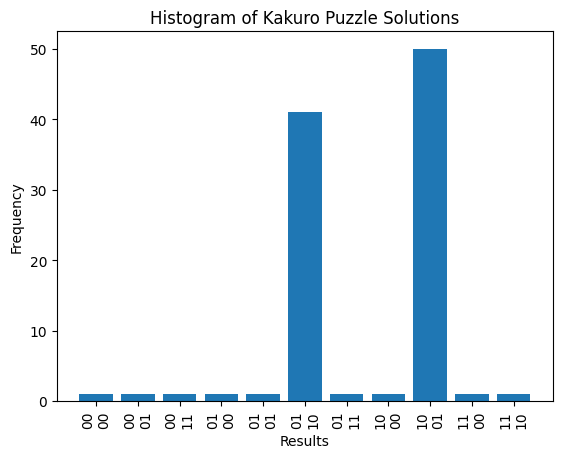

In [7]:
(row_constr, col_constr) = ([1, 1], [1, 1])
iterations = 2
shots = 100

results = qsharp.run(f"KakuroGroversSearch({iterations}, {row_constr}, {col_constr})", shots=shots)
R = len(row_constr)
C = len(col_constr)
res_str = ["".join([("\n" if i > 0 and i % C == 0 else "") + ("1" if res[i] == qsharp.Result.One else "0") for i in range(R * C)]) for res in results]
plot_results(res_str)

Edit the number of iterations in the code cell below and run it to plot the results. **Which of the results are correct puzzle solutions?**

* 001 110 010
* 010 011 100
* 010 010 101
* 010 100 001
* 100 011 010

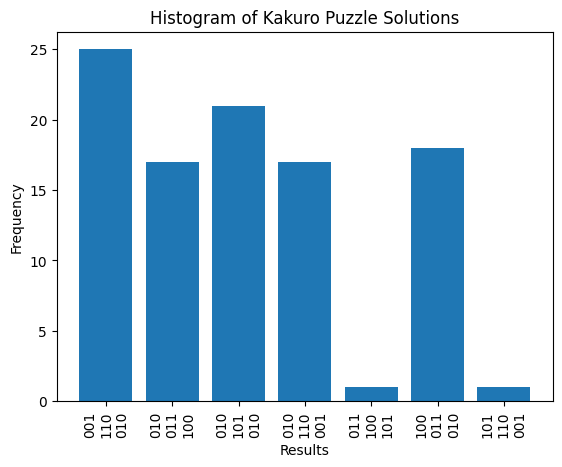

In [17]:
(row_constr, col_constr) = ([1, 2, 1], [1, 2, 1])
iterations = 7
shots = 100

results = qsharp.run(f"KakuroGroversSearch({iterations}, {row_constr}, {col_constr})", shots=shots)
R = len(row_constr)
C = len(col_constr)
res_str = ["".join([("\n" if i > 0 and i % C == 0 else "") + ("1" if res[i] == qsharp.Result.One else "0") for i in range(R * C)]) for res in results]
plot_results(res_str)